## Redes neuronales II. PyTorch
___

### 1. El módulo _nn_
---
PyTorch disponde de un submódulo específico para redes neuronales, el módulo **_torch.nn_**. Contiene todos los bloques constructivos necesarios para crear todo tipo de arquitecturas de redes neuronales. 

Estos bloques fundacionales se denominan **_módulos_** en PyTorch. Básicamente, son clases que derivan de **_nn.Module_**. Pueden tener una o más instancias de **_Parameter_** como atributos, los cuales son **tensores** que serán optimizados durante el proceso de entrenamiento. Un módulo podría tener también otros submódulos (subclases de _nn.Module_) como atributos y monitorizar sus parámetros.

Uno de estos módulos es la subclase **_nn.Linear_** que proporciona una transformación lineal afín de su entrada (a través de los parámetros _weight_ y _bias_) como luego veremos al reescribir nuestro ejemplo del termómetro.


#### 1.1 Usando \_\__call_\_\_ en lugar de _forward_
---
Todas las subclases del módulo _nn.Module_ tienen definido el método \_\__call_\_\_. Esto nos permitiría instanciar un _nn.Linear_ e invocarlo como si fuera una función.


In [1]:
import torch
import torch.nn as nn

t_un_val = torch.ones([1]) 
linear_model = nn.Linear(1, 1) # input size=1, output_size=1, bias=True
linear_model(t_un_val)

tensor([0.0622], grad_fn=<AddBackward0>)

Invocar una instancia de _nn.Module_ con un conjunto de argumentos deriva en la llamada al método **_forward_** con los mismos argumentos. En teoría, podemos llamar directamente a este método. Sin embargo, no debemos hacerlo pues en la propia función \_\__call_\_\_ se realizan diversas "preparaciones" antes de invocar el método _forward_.

### 1.2 _nn.Linear_
___
Volviendo a nuestro modelo lineal, el contructor de _nn.Linear_ acepta tres argumentos: el número de parámetros de entrada (_input features_), el número de valores de salida (_output feaures_) y si el modelo incluye _bias_ (por defecto, _True_).

Dado que sólo definimos un parámetro de entrada, nuestro modelo sólo tendrá un peso (_w_) (el _bias_ está a True por defecto)

In [2]:
linear_model.weight

Parameter containing:
tensor([[-0.1404]], requires_grad=True)

In [3]:
linear_model.bias

Parameter containing:
tensor([0.2026], requires_grad=True)

El método **_parameters()_** devuelve un generador que nos permite acceder a la colección de parámetros (incluído _bias_)

In [4]:
# traverse parameters
for p in linear_model.parameters():
    print(p)
    
# create a list
list(linear_model.parameters())

Parameter containing:
tensor([[-0.1404]], requires_grad=True)
Parameter containing:
tensor([0.2026], requires_grad=True)


[Parameter containing:
 tensor([[-0.1404]], requires_grad=True),
 Parameter containing:
 tensor([0.2026], requires_grad=True)]

##### 1.2.1 Batching inputs
---
En nuestro ejemplo anterior, sólo proporcionamos una única **muestra** (_sample_) al modelo. Normalmente, la entrada consistirá en un _batch_ conteniendo múltiples muestras. Esta entrada será un tensor de tamaño **_B x N_\__in_**, donde _B_ es el tamaño del _batch_ y _N_\__in_ el número de parámetros de entrada (_input features_).

Por su parte, la salida será un tensor de tamaño **_B x N_\__out_**, donde _B_ es el tamaño del _batch_ y _N_\__out_ el número de valores de la salida (_output features_)

Por ejemplo,

In [5]:
x = torch.ones([10, 1])
linear_model(x)

tensor([[0.0622],
        [0.0622],
        [0.0622],
        [0.0622],
        [0.0622],
        [0.0622],
        [0.0622],
        [0.0622],
        [0.0622],
        [0.0622]], grad_fn=<AddmmBackward>)

En la siguiente imagen, se puede observar una situación similar. En este caso, la entrada será  **_B x C x H x W_** in consitirá en un _batch_ de 3 imágenes, 3 canales y un número determinado de píxeles. La salida será un tensor de **_B x N_\__out_**, siendo _N_\__out_ = 4 en este caso.

<br>

![data/image-lect/rgb_batch.png](data/image-lect/rgb_batch.png)

<br>


##### 1.2.1.1 Optimizando los batches
___
Las razones para enviar las muestras a la red neuronal en _batches_ son varias. Por un lado, se aprovecha mejor el alto grado de paralelización proporcionado por las GPU's. Por otro, algunos modelos avanzados, emplean informción estadística a partir del _batch_.

Volviendo a nuestro ejemplo del termómetro, tanto **t_u** como **t_c** son tensores **1D**, por lo que debemos convertirlos en **matrices** donde las filas representan las **muestras** (_samples_) y las columnas los **atributos** (_features_)

In [6]:
# temperaturas ºC
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]

# temperaturas en escala desconocida (unknown)
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c).unsqueeze(1) # añade la nueva dimensión en el eje 1
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape, t_c.shape

(torch.Size([11, 1]), torch.Size([11, 1]))

Vamos a actualizar ahora nuestro código para el entrenamiento

In [7]:
import torch.nn as nn
import torch.optim as optim

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

Lógicamente, nuestra función de entrenamiento va a sufrir pequeñas modificaciones. En lugar de pasarle los parámetros iniciales, le pasaremos el **modelo**. En lugar de emplear nuestra propia función de _loss_, le pasaremos una de las definidas en PyTorch

In [43]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train) # usamos el modelo suministrado
        loss_train = loss_fn(t_p_train, t_c_train)  # calcula el error con la loss_funcion indicada
        
        t_p_val = model(t_u_val) # validación
        loss_val = loss_fn(t_p_val, t_c_val)  

        optimizer.zero_grad()  # inicializa los gradientes
        loss_train.backward()        # calcula los gradientes
        optimizer.step()       # actualiza los parámetros
        
        if epoch==1 or epoch%1000==0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                    f" Validation loss {loss_val.item():.4f}")

Probemos el nuevo modelo...

In [9]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

# training dataset
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

# validation dataset
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

# normalization (if necessary)
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train=train_t_un,
    t_u_val=val_t_un,
    t_c_train=train_t_c,
    t_c_val=val_t_c)

Epoch 1, Training loss 349.1432, Validation loss 68.2939
Epoch 1000, Training loss 5.2327, Validation loss 2.1905
Epoch 2000, Training loss 3.2498, Validation loss 1.5185
Epoch 3000, Training loss 3.0666, Validation loss 2.7755


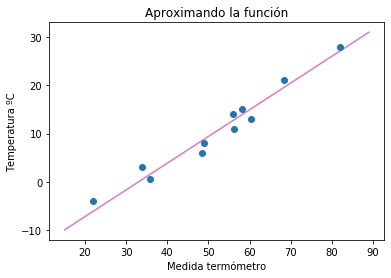

In [10]:
from matplotlib import pyplot as plt

t_x = torch.arange(15, 90).unsqueeze(1)
t_nx = 0.1*t_x # normalize

t_p = linear_model(t_nx) # predictions

plt.plot(t_x, t_p.detach().numpy(), '#e377c2', zorder=1) # visualize
plt.scatter(t_u, t_c, zorder=2)

plt.title("Aproximando la función")
plt.ylabel("Temperatura ºC")
plt.xlabel("Medida termómetro")
plt.show()

### 1.3 _nn.Sequential_
___
Vamos a reemplazar nuestro modelo lineal por una **red neuronal** como función de aproximación. Dado que, en este caso, nuestro problema es fundamentalmente lineal, esta solución no es la más apropiada pero nos servirá como ejemplo de implementación.

Del código anterior, sólo tendremos que reemplazar el **modelo**. Construiremos la red neuronal más simple posible: un módulo lineal seguido por una función de activación que, a su vez, alimentarán otro módulo lineal. La primera capa (primer módulo lineal + activación) se denomina **_capa oculta (hidden layer)_**, ya que su salida no es directamente observable sino que alimenta a la **_capa de salida (output layer)_**. Mientras que la entrada y salida de la red son ambos 1 (en este caso), la salida del primer módulo lineal es generalmente mayor que 1. Esto deriva en que diferentes unidades de nuestro modelo responderán a rangos diferentes de la entrada, lo que incrementa la capacidad de nuestro modelo. La última capa lineal combinará linealmente las salidas de las activaciones de la _capa oculta_ para producir el valor de salida.

En la siguiente imagen, podemos ver dos formas alternativas de representar redes neuronales:

<br>

![data/image-lect/ann_repr.png](data/image-lect/ann_repr.png)

<br>

#### 1.3.1 _nn.Sequential_
___
El módulo **_nn_** proporciona un mecanismo simple para la concatenación de módulo: el contenedor **_nn.Sequential_**

In [11]:
seq_model = nn.Sequential(
            nn.Linear(1, 13),
            nn.Tanh(),
            nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

El modelo anterior recibe un atributo de entrada (_feature_) y lo deriva sobre 13 unidades, cada una con su función lineal (con sus correspondientes parámetros, tantos como _input features_ más el _bias_) y su función de activación (_tanh_ en este caso). Las salidas de estas unidades se combinan _linealmente_ para generar una única salida (1 _output feature_)

##### 1.3.1.1 Inspeccionando los parámetros
___
La invocación de **_model.parameters()_** nod devolverá el **_weight_** y **_bias_** del primer y segundo módulos lineales.

In [18]:
# params shape
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [27]:
params = list(seq_model.parameters())
print("HIDDEN LAYER:")
print(f"--> hidden_layer linear weights [unit, w]: {params[0].shape}\n{params[0]}")
print(f"--> hidden_layer linear bias [unit, b]: {params[1].shape}\n{params[1]}")
print("OUTPUT LAYER:")
print(f"--> output_layer linear weights [unit, w]: {params[2].shape}\n{params[2]}")
print(f"--> output_layer linear bias [unit, b]: {params[3].shape}\n{params[3]}")

HIDDEN LAYER:
--> hidden_layer linear weights [unit, w]: torch.Size([13, 1])
Parameter containing:
tensor([[-0.4706],
        [-0.9453],
        [-0.9112],
        [-0.6549],
        [-0.4481],
        [-0.8820],
        [ 0.4000],
        [-0.7400],
        [ 0.7559],
        [ 0.1205],
        [-0.2735],
        [-0.3420],
        [-0.5090]], requires_grad=True)
--> hidden_layer linear bias [unit, b]: torch.Size([13])
Parameter containing:
tensor([-0.6323,  0.6508,  0.3101,  0.7852, -0.6560, -0.4273, -0.3161,  0.0783,
        -0.3875,  0.6387, -0.5971, -0.0456, -0.0661], requires_grad=True)
OUTPUT LAYER:
--> output_layer linear weights [unit, w]: torch.Size([1, 13])
Parameter containing:
tensor([[-0.1106, -0.2771, -0.2056, -0.2535, -0.2681,  0.2159,  0.0320, -0.0974,
         -0.2637,  0.2323, -0.2323,  0.0878, -0.0679]], requires_grad=True)
--> output_layer linear bias [unit, b]: torch.Size([1])
Parameter containing:
tensor([0.1662], requires_grad=True)


           tanh(w1_0*a0 + b1_0) = z1_0
           tanh(w1_1*a0 + b1_1) = z1_1
    a0 --> tanh(w1_2*a0 + b1_2) = z1_2 --> (w2_0*z1_0 + w2_1*z1_1 + ... + 
                                            w2_12*z1_12 + b2_0)
                ... (13) ...
           tanh(w1_12*a0 + b1_12) = z1_12

          

En general, cuando inspeccionamos los parámetros de de un modelo formado por varios submódulos, es conveniente identificar los parámetros por nombre. Existe un método para ello denominado **_named_\__parameters_**. El nombre de cada módulo será simplemente el ordinal del módulo cuando fue creada la secuencia.

In [30]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


Por otro lado, **_Sequential_** también acepta un **_OrderedDict_** en el que podemos indicar el nombre de cada módulo:

In [47]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
            ('hidden_linear', nn.Linear(1, 8)),
            ('hidden_activation', nn.Tanh()),
            ('output_linear', nn.Linear(8, 1))
]))

for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


Además podremos acceder directamente a un _Parameter_ usando el _submodulo_ como atributo

In [34]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.3330], requires_grad=True)

##### 1.3.1.2 Probando el nuevo modelo
___
Para probar el nuevo modelo, no tenemos más que pasárselo a nuestro nuevo método de entrenamiento

In [48]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <-- parameters del nuevo modelo
training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,       # <-- ANN model
    loss_fn=nn.MSELoss(),
    t_u_train=train_t_un,
    t_u_val=val_t_un,
    t_c_train=train_t_c,
    t_c_val=val_t_c)

Epoch 1, Training loss 226.9303, Validation loss 42.8379
Epoch 1000, Training loss 5.1758, Validation loss 2.1434
Epoch 2000, Training loss 5.5477, Validation loss 4.3047
Epoch 3000, Training loss 3.1169, Validation loss 5.3812
Epoch 4000, Training loss 2.2835, Validation loss 6.1796
Epoch 5000, Training loss 2.0433, Validation loss 6.6167


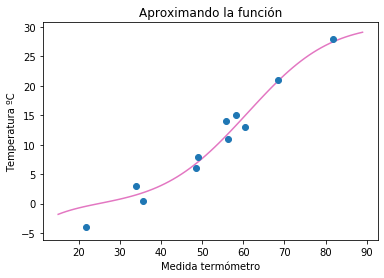

In [49]:
from matplotlib import pyplot as plt

t_x = torch.arange(15, 90).unsqueeze(1)
t_nx = 0.1*t_x # normalize

t_p = seq_model(t_nx) # predictions

plt.plot(t_x, t_p.detach().numpy(), '#e377c2', zorder=1) # visualize
plt.scatter(t_u, t_c, zorder=2)

plt.title("Aproximando la función")
plt.ylabel("Temperatura ºC")
plt.xlabel("Medida termómetro")
plt.show()